In [1]:
# 1 : Downloaded dataset , 400 images in ATT file , 40 person , each has 10 images

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


        
    

In [11]:
# here are some nice fuctions !!!
def printImg (arr): # send a vector here to print image !!
         arr = arr.reshape(112,92)
         plt.imshow(arr , cmap = "gray")
         plt.show()

def getR(eigVals , alpha):
    TotalSum = np.sum(eigVals) # sum of all eigen values
    Sum = 0 # sum of r eigen values , 
    r = 0 # r represents number of dimensions
    for val in eigVals:
        Sum += val # Sigma alphas starting with the largest
        r+=1
        if(Sum/TotalSum >=alpha): # if sum is greater than tolerance
            break # break gives least sum less than tolerance
    return r
    

def getLabel(labels , nDistances):
    classes = list(dict.fromkeys(labels))
    classCount = [labels.count(i) for i in classes] 
    classCount, classes = zip(*sorted(zip(classCount, classes)))
    maxCount = classCount.count(classCount[-1])
    if(maxCount == 1):
        return classes[-1]

    maxClasses = []
    for i in range(len(classes)):
        if(classCount[i] == classCount[-1]):
            maxClasses.append(classes[i])
 
   
    maxSum = [0]*len(maxClasses)
    for i in range(len(maxClasses)):
        for j in range(len(labels)):
            if(labels[j] == maxClasses[i]):
                maxSum[i] += nDistances[j]
                maxSum = list(maxSum)

    maxSum, maxClasses = zip(*sorted(zip(maxSum, maxClasses)))
    
    return maxClasses[0]


    
    
   
    
def kNN(k ,tested , train , trainLabels):
    nNeighbours = [0]*k # List of indicies of k nearest neighbours
    nDistances = [float('inf')]* k # List of distances with k nearest neighbours
    elementIndex = 0  #index of each element in each trainProj
    for trained in train:
        distance = np.linalg.norm(tested-trained)
        if(distance < nDistances[-1]):
            nNeighbours = list(nNeighbours)
            nNeighbours[-1] = elementIndex
            nDistances = list(nDistances)
            nDistances[-1] = distance
        elementIndex +=1
        nDistances, nNeighbours = zip(*sorted(zip(nDistances, nNeighbours)))

    labels = [trainLabels[i] for i in nNeighbours]
    return getLabel( labels , nDistances )

In [12]:
# 2 


people = 40
images = 10
dataset = np.empty((0,10304), int) # 400 x 10304 dataset matrix

for i in range(people): # for each of 40 people
     for j in range(images): # load the 10 images
         string = str(i+1)+"_"+str(j+1)+".png" # make image name ex:1_1.png
         img = Image.open('./ATT/'+string) #open image 
         arr = np.array(img)   # change image to numpy array
         arr = arr.reshape(1,10304)  # reshape to a vector
         dataset = np.append(dataset,arr, axis=0) # append to dataset matrix
         

# for img in dataset: #use this code to print all images , there is alot though!
#      printImg(img)

print(dataset.shape) # check the shape of the dataset , correct !!!



#  and generate the label vector y.
# The labels are integers from 1:40 corresponding to the subject id
# mesh fahem 3ayez eh ?

labels = []  # like this for now
for i in range(people):
    for j in range(images):
        labels.append(i+1)

(400, 10304)


In [10]:
dataset[90,:]

array([140, 134, 135, ...,  25,  26,  49])

In [13]:
# 3
# counting rows starts at 0 not 1
train = dataset[1::2] # odd indexed vectors
trainLabels = labels[1::2] # odd indexed labels
test = dataset[0::2] # even indexed vectors
testLabels = labels[0::2] # even indexed labels

In [ ]:
# 4 , part one starting pca
alpha = [0.8,0.85,0.9,0.95]
meanVecs = []
for i in range(10304): # compute mean for each of 10304 column
    meanVecs.append([np.mean(train[:,i])])

    meanMat = np.array(meanVecs) # mean matrix 10304 X 1
zTrain = train - meanMat.T # zTrain the mean train matrix

covMat =  (1/len(zTrain))*np.matmul(np.transpose(zTrain),zTrain)


eigVals,eigVecs = np.linalg.eigh(covMat) # eigen values and vectors of covariance MAtrix
# note this takes around 15 minutes

idx = eigVals.argsort()[::-1]  # sort eigen values in descending order along with coresponding eigen values 
eigVals = eigVals[idx]
eigVecs = eigVecs[:,idx] 

rList = [] # contains r for each alpha 
for el in alpha:
    rList.append(getR(eigVals , el))

projMat = [] #list of projection matricies for each alpha
projMat = [eigVecs[:,:i] for i in rList]

trainProj = [] # list of projections , each project is of the train on one of the projection matricies
for mat in projMat:
    trainProj.append(train.dot(mat))
    
testProj = [] # list of projections , each project is of the test on one of the projection matricies
for mat in projMat:
    testProj.append(test.dot(mat))
    


In [15]:
dataset

array([[ 48,  49,  45, ...,  47,  46,  46],
       [ 60,  60,  62, ...,  32,  34,  34],
       [ 39,  44,  53, ...,  29,  26,  29],
       ...,
       [125, 119, 124, ...,  36,  39,  40],
       [119, 120, 120, ...,  89,  94,  85],
       [125, 124, 124, ...,  36,  35,  34]])

In [17]:
# 4 part two , getting predicted labels for projTest for each alpha 
k=1
predictedTestLabels = [] # a list of lists of predicted labels , each depending on alpha used 
for dataIndex in range(len(testProj)): # index of dataset from testProj and trainPorj
    predictedLabels = []
    for tested in testProj[dataIndex]:
        predictedLabels.append(kNN(k , tested , trainProj[dataIndex] , trainLabels))
    predictedTestLabels.append(predictedLabels)
        


In [18]:
#4 part three , calculating accuracies per alpha
accuracyList = [] # list of 4 elements , each represents the accuracy of an alpha
actualLabels = np.array(testLabels)
for labels in predictedTestLabels:
    labels = np.array(labels)
    correct = labels.shape[0] - np.count_nonzero(labels-actualLabels)
    accuracy = correct / labels.shape[0] *100
    accuracyList.append(accuracy)


[93.0, 94.0, 94.5, 93.5]


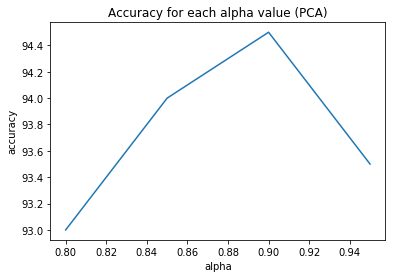

As alpha increases accuracy increase , peak at 0.9


In [19]:
#4 part four , analyzing accuracies
print(accuracyList)
plt.plot(alpha,accuracyList)
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy for each alpha value (PCA)")
plt.show()
print("As alpha increases accuracy increase , peak at 0.9")

In [11]:
#4 part five , getting accuracies for each alpha for each k
kRange = [1,3,5,7]
actualLabels = np.array(testLabels)
predictedTestLabels = [] # predicted labels for each alpha for each value of k
for dataIndex in range(len(testProj)): # index of dataset from testProj and trainPorj
    for k in kRange:
        predictedLabels = []
        for tested in testProj[dataIndex]:
            predictedLabels.append(kNN(k , tested , trainProj[dataIndex] , trainLabels))
        predictedTestLabels.append(predictedLabels)

        
accuracyList = [] # list of 4 elements , each represents the accuracy of an alpha
for labels in predictedTestLabels:
    labels = np.array(labels)
    correct = labels.shape[0] - np.count_nonzero(labels-actualLabels)
    accuracy = correct / labels.shape[0] *100
    accuracyList.append(accuracy)




Legend shows alpha values


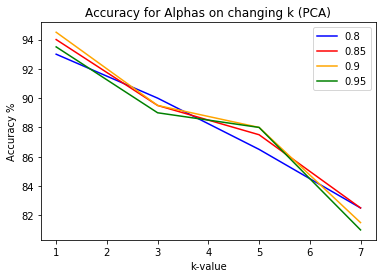

In [12]:
#4 part six , analyzing accuracies for each alpha on changin k
index = 0
alphaRange = [0.8,0.85,0.9,0.95]
colors = ['blue','red' , 'orange' ,'green']
for (alpha,color) in zip(alphaRange,colors):
    plt.plot(kRange,accuracyList[index:index+4] , color = color , label = alpha)
    index +=4
    plt.title("Accuracy for Alphas on changing k (PCA)")
    plt.xlabel("k-value")
    plt.ylabel("Accuracy %")
plt.legend(loc='upper right')
plt.show
print("Legend shows alpha values")



In [13]:
#5 part one , starting the LDA
labels = np.array(trainLabels)
meanList = [np.mean(train[labels == i+1] , axis=0) for i in range(40)] # list having mean vectors per class
mean = np.mean(train , axis = 0) # overall sample mean

Sb = np.empty((10304,10304), float)
for i in range(40):
    Sk = (meanList[i] - mean).reshape(10304,1) @ (meanList[i] - mean).reshape(1,10304) # S value for each k
    Sb += Sk
Sb = 5*Sb # since all classes have 5 samples , nk =5 , constant , done once out of summation
# this takes a minute

In [14]:
#5 part two , S matrix 

Zk = [train[labels == i+1] - meanList[i] for i in range(40)] # list of matricies , each has centralised members of one class only
S = np.empty((10304,10304),float) # S matrix

for mat in Zk :
    Sn = mat.T @ mat   # S matrix for each class n
    S += Sn
# this takes a minute



In [15]:
#5 part three , matrix on which we take eigens
Sinv = np.linalg.inv(S)
mat = Sb @ Sinv 
# hhhhhh , this also takes some time

In [16]:
#5 part four , eigens !!!!!!
eigVals2 , eigVecs2 = np.linalg.eig(mat)
# takes about 15 minutes

In [17]:
#5 part five , sort eigens and project
idx = eigVals2.argsort()[::-1]  # sort eigen values in descending order along with coresponding eigen values 
eigVals2 = eigVals2[idx]
eigVecs2 = eigVecs2[:,idx] 

projMat = eigVecs2[:,:39]
trainProj2 = train @ projMat
testProj2 = test @ projMat

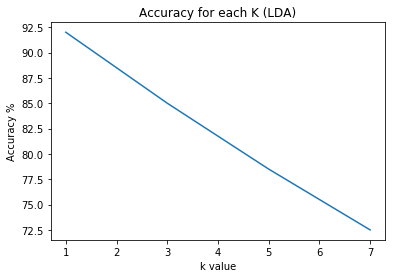

In [18]:
#5 part six, get predicted labels and accuracies for each k
kRange = [1,3,5,7]
accuracies = []
actualLabels = np.array(testLabels)
for k in kRange:
    predictedLabels2 = [] # list of predicted labels
    for tested in testProj2:
        predictedLabels2.append(kNN(k , tested , trainProj2 , trainLabels))
    predictedLabels2 = np.array(predictedLabels2)
    correct = actualLabels.shape[0] - np.count_nonzero(actualLabels-predictedLabels2)
    accuracy = correct / actualLabels.shape[0] *100
    accuracies.append(accuracy)

plt.plot(kRange , accuracies)
plt.xlabel("k value")
plt.ylabel("Accuracy %")
plt.title("Accuracy for each K (LDA)")
plt.show()


